In [5]:
import numpy as np
from matplotlib import pyplot as  plt
import networkx as nx
import random
import itertools
from itertools import product
import scipy.sparse as sp
import scipy.io
import csv
import collections
import seaborn as sns


In [6]:
'''This Utiliy just displays the graph with edge weights'''
def show_graph(G):
    plt.figure()
    pos = nx.spring_layout(G)     #you can toggle between spring_layout and circular
    #pos = nx.circular_layout(G)
    nx.draw(G,pos)
    nx.draw_networkx_labels(G, pos);
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
 
'''This plots the graph without edgeout weights shown'''
def show_graph_nw(G):
    plt.figure()
    pos = nx.spring_layout(G)
    #pos = nx.circular_layout(G)
    nx.draw(G,pos)
    nx.draw_networkx_labels(G, pos);   
    
'''Generate a random erdos renyi graph n,p, and randomly assigns weights'''
def random_graph_generator(n,p):
    G=nx.gnp_random_graph(n, p, directed=True)
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(1,100)
    G=G.subgraph(max(nx.strongly_connected_components(G), key=len))
    return G 

'''Generate a random erdos renyi graph n,p, and randomly assigns weights AND nomralizes each row to equal 1'''
def random_graph_norm(n,p):
    G=nx.gnp_random_graph(n, p, directed=True)
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(1,100)
    for n in G.nodes():
        ww=[x[2] for x in G.out_edges(n,data='weight')]
        tt=sum(ww)
        for ee in G.out_edges(n):
            G[ee[0]][ee[1]]['weight']/=tt
    G=G.subgraph(max(nx.strongly_connected_components(G), key=len))
    
    return G 

In [7]:
'''This cell contains functions to choose which node (or edge) is specialized next, you can add other function here you want to try'''

'''chooses the NODE with the highest eigenvector centrality'''
def ev_centrality_node(G):
    l=nx.eigenvector_centrality(G,weight='weight',tol=1e-03)

    max_key = max(l, key=l.get)
    return max_key

'''chooses the EDGE with the highest betweeness centrality'''
def maxBetweenessEdge(G):
    nodes = [x for x in G.nodes() if (len(G.in_edges(x))>0 and len(G.out_edges(x))>0)  ]
    bc_dict = nx.edge_betweenness_centrality(G, weight="weight")
    i=0
    bc_list=list(sorted(bc_dict.keys(), key=bc_dict.get))
    #print(bc_list)
    while i<len(bc_list):
        if int(bc_list[i][1]) in nodes:
            edge = bc_list[i]
            #print(edge)
            break
        i+=1
    return edge

'''Choose the NODE with the highest betweenness centrality'''
def maxBetweenessNode(G):
    nodes = [x for x in G.nodes() if (len(G.in_edges(x))>0 and len(G.out_edges(x))>0)  ]
    bc_dict = nx.edge_betweenness_centrality(G, weight="weight")
    i=0
    bc_list=list(sorted(bc_dict.keys(), key=bc_dict.get))
    #print(bc_list)
    while i<len(bc_list):
        if int(bc_list[i][1]) in nodes:
            edge = bc_list[i]

            #print(edge)
            break
        i+=1
    return edge[1]
""" Use this One for the Edge function going in.
    Write one for Going out
"""
def maxEigenvalueIn(G):
    nodes = [x for x in G.nodes() if (len(G.in_edges(x))>2 and len(G.out_edges(x))>0)  ]
    bc_dict = nx.eigenvector_centrality(G, weight="weight",tol=1e-03)
    edge = None
    i=0
    bc_list=list(sorted(bc_dict.keys(), key=bc_dict.get, reverse = True))
    while i<len(bc_list):
        if int(bc_list[i]) in nodes:
            node = bc_list[i]
            #print(edge)
            break
        i+=1
    ends = [e[0] for e in G.in_edges(node)]
    i = 0
    while i < len(bc_list):
        if int(bc_list[i]) in ends:
            node2 = bc_list[i]
            edge = (node2,node)
            break
        i +=1

    return edge

def maxEigenvalueOut(G):
    nodes = [x for x in G.nodes() if (len(G.in_edges(x))>0 and len(G.out_edges(x))>2)]
    

    bc_dict = nx.eigenvector_centrality(G, weight="weight",tol=1e-03)
 

    i=0
    edge = None
    bc_list=list(sorted(bc_dict.keys(), key=bc_dict.get, reverse = True))


    while i<len(bc_list):
        if int(bc_list[i]) in nodes:
            node = bc_list[i]
            #print(edge)
            break
        i+=1
    
    
    ends = [e[1] for e in G.out_edges(node)]
    i = 0
    while i < len(bc_list):
        if int(bc_list[i]) in ends:
            node2 = bc_list[i]
            edge = (node,node2)
            break
        i +=1
    return edge
        
    
        
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#


'''Specializes a single in-edge (chosen by f)'''
def singleNodeSpecializeIn(Gc, f): #f returns the edge to specialize
    G=Gc.copy() 
    if type(f) is tuple:
        edge = f
    else:
        edge = f(G)
    if edge is None:
        return G, True
    node = edge[1]
    newNode = (G.subgraph(node)).copy()   
    if len(G.in_edges(node))<2:
            return G, False
    newEdges = G.out_edges(node, data="weight")
    for e in newEdges:
        newNode.add_weighted_edges_from([(node,e[1],e[2])])
    newNode.add_weighted_edges_from([(edge[0],edge[1],G[edge[0]][edge[1]]['weight'])])
    newNode = nx.relabel_nodes(newNode, {node:max(G.nodes())+1})
    G.remove_edges_from([edge])
    return nx.compose(newNode,G), True

'''Specializes a single out-edge (chosen by f)'''
def singleNodeSpecializeOut(Gc, f): #f returns an edge
    G=Gc.copy() 
    if type(f) is tuple:
        edge = f
    else:
        edge = f(G)
 
    if edge is None:

        return G, False
    node = edge[0]
    newNode = (G.subgraph(node)).copy()
    w=G[edge[0]][edge[1]]['weight']
    #print(node)
    if len(G.out_edges(node))<2:
            return G, False        
    newEdges = G.in_edges(node, data="weight")
    for e in newEdges:
        newNode.add_weighted_edges_from([(e[0],node,e[2]*w)])
    newNode.add_weighted_edges_from([(edge[0],edge[1],1)])
    newNode = nx.relabel_nodes(newNode, {node:max(G.nodes())+1})
    G.remove_edges_from([edge])
    #show_graph(newNode)
    for e in G.in_edges(node):
        G[e[0]][e[1]]['weight']*=(1-w)
    for e in G.out_edges(node):
        G[e[0]][e[1]]['weight']/=(1-w)
    return nx.compose(newNode,G), True

'''Completely Specializes all edges (in and out) adjacenct to a node chosen by f'''
def singleNodeSpecialize_Complete(Gc, f): #This f returns a node to specialize!
    G=Gc.copy() 
    original_nodes=G.nodes()
    #print(original_nodes)
    if type(f) is int:
        node = f
    else:
        node = f(G)
    in_edges = G.in_edges(node)
    for e in in_edges:
        G,t = singleNodeSpecializeIn(G, e)
    newNodes = list(set(G.nodes()-set(original_nodes)))
    #print(newNodes)
    #show_graph(G)
    newNodes.append(node)
    for node2 in newNodes:
        out_edges = G.out_edges(node2)
        for e in out_edges:
            G,t = singleNodeSpecializeOut(G, e)    
    return G

'''Completely specializes all OUT edges adjacent to a node chosen by f'''
def singleNodeSpecialize_CompleteOut(Gc, f): #This f returns a node to specialize!
    G=Gc.copy() 
    original_nodes=G.nodes()
    #print(original_nodes)
    if type(f) is int:
        node = f
    else:
        node = f(G)
    out_edges = G.out_edges(node)
    for e in out_edges:
        G,t = singleNodeSpecializeOut(G, e)    
    return G

'''Completely specializes all IN edges adjacent to a node chosen by f'''
def singleNodeSpecialize_CompleteIn(Gc, f): #This f returns a node to specialize!
    G=Gc.copy() 
    original_nodes=G.nodes()
    #print(original_nodes)
    if type(f) is int:
        node = f
    else:
        node = f(G)
    in_edges = G.in_edges(node)
    for e in in_edges:
        G,t = singleNodeSpecializeIn(G, e)
    return G


In [8]:
def variance_ev(G): ## function to compute variance of eigenvector centrality
    evec_dict = nx.eigenvector_centrality(G)
    evec = list(evec_dict.values())
    evec = np.array(evec)
    evec/= np.linalg.norm(evec, ord = 1)
    return np.std(evec)**2

# Procedure for Single In/Out Specialization
### use the functions singleNodeSpecializeOut or singleNodeSpecializein, with the second argument as maxEigenvalueOut or maxEigenvalueIn respectively

Note that this takes a while to run to create a graph as large as only running the other types of specialization a few times

Also, singleNodeSpecializeOut/In returns a thrid argument unlike the other functions,
which is a flag. If the flag is false, that means there aren't anymore nodes to specialize and we stop.

## Example

74
100


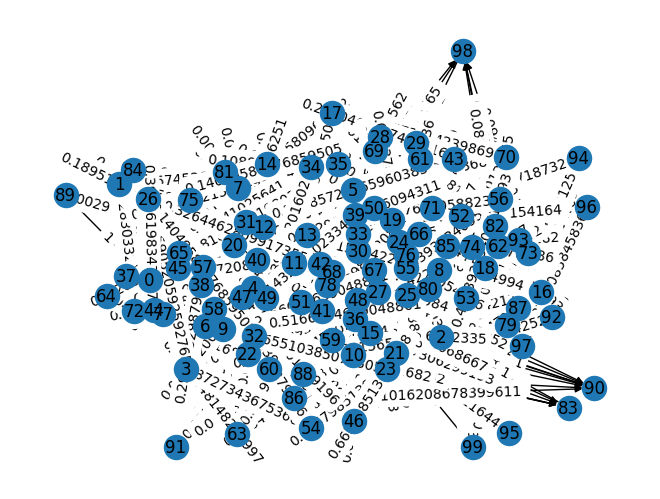

In [13]:

G = random_graph_norm(25,.25) #Generate Random Graph
num_nodes = [len(G.nodes)]
diameters = [nx.diameter(G)]
variance = [variance_ev(G)]
density = [nx.density(G)]

G,flag = singleNodeSpecializeOut(G,maxEigenvalueOut)  #you can switch out how we choose the node here

num_nodes.append(len(G.nodes))
diameters.append(nx.diameter(G))
variance.append(variance_ev(G))
density.append(nx.density(G))

count=0
while(G.number_of_nodes()<100 and count<100 and flag):#specialize until we have more than 3000 nodes or 25 times. 
    num_nodes.append(len(G.nodes))
    diameters.append(nx.diameter(G))
    variance.append(variance_ev(G))
    density.append(nx.density(G))
    
    G,flag = singleNodeSpecializeOut(G,maxEigenvalueOut)
    count+=1
print(count)
print(G.number_of_nodes())
show_graph(G)


# Procedure for Complete In/Out Specialization
### use the functionssingleNodeSpecialize_CompleteOut orsingleNodeSpecialize_CompleteIn, with the second argument as ev_centrality_node for either case



## Example

In [10]:
G = random_graph_norm(25,.25) #Generate Random Graph
num_nodes = [len(G.nodes)]
diameters = [nx.diameter(G)]
variance = [variance_ev(G)]


G = singleNodeSpecialize_CompleteOut(G,ev_centrality_node)  #you can switch out how we choose the node here
num_nodes.append(len(G.nodes))
diameters.append(nx.diameter(G))
variance.append(variance_ev(G))
count=0
while(G.number_of_nodes()<500 and count<500): #specialize until we have more than 3000 nodes or 25 times. 
    G  = singleNodeSpecialize_CompleteOut(G,ev_centrality_node)
    count+=1
    num_nodes.append(len(G.nodes))
    diameters.append(nx.diameter(G))
    variance.append(variance_ev(G))
print(count)
print(G.number_of_nodes())

14
861


# Procedure for Complete Specialization
### use the functionssingleNodeSpecialize_Complete with the second argument as ev_centrality_node 

## Example

In [11]:
'''Here I do a complete out specialization chosing te highest evc'''

G = random_graph_norm(25,.25) #Generate Random Graph
num_nodes = [len(G.nodes)]
diameters = [nx.diameter(G)]
variance = [variance_ev(G)]
density = [nx.density(G)]


G = singleNodeSpecialize_Complete(G,ev_centrality_node)  #you can switch out how we choose the node here
num_nodes.append(len(G.nodes))
diameters.append(nx.diameter(G))
variance.append(variance_ev(G))
density.append(nx.density(G))
count=0
while(G.number_of_nodes()<5000 and count<1000): #specialize until we have more than 3000 nodes or 25 times. 
    G  = singleNodeSpecialize_Complete(G,ev_centrality_node)
    count+=1
    num_nodes.append(len(G.nodes))
    diameters.append(nx.diameter(G))
    variance.append(variance_ev(G))
    density.append(nx.density(G))
    
print(count)
print(G.number_of_nodes())
#show_graph(G)

7
11103


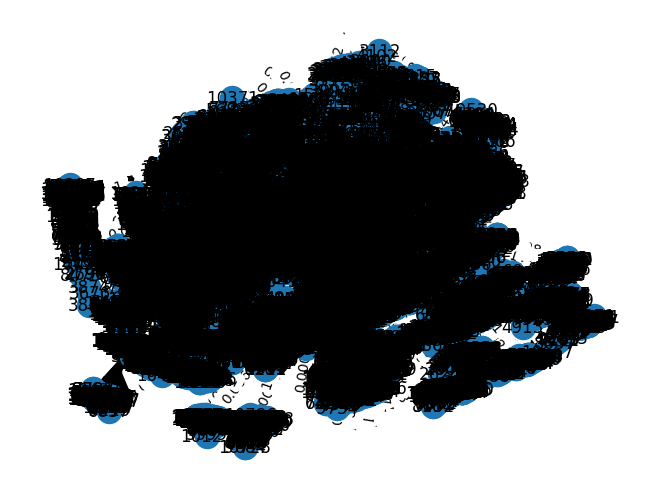

In [12]:
show_graph(G)